### EigenPhi bid value simple anlysis 
Extract all bid csv from the page: https://bidarchive.relayscan.io/ethereum/mainnet/2024-06/index.html


In [2]:
import requests
from bs4 import BeautifulSoup
import zipfile
import io
import pandas as pd
import re

# URL of the page containing the ZIP file links
index_url = "https://bidarchive.relayscan.io/ethereum/mainnet/2024-06/index.html"

# Fetch the content of the page
response = requests.get(index_url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract all links that match the pattern
zip_urls = []
for link in soup.find_all('a', href=True):
    href = link['href']
    if re.match(r'\d{4}-\d{2}-\d{2}_all\.csv\.zip$', href):
        zip_urls.append(index_url.rsplit('/', 1)[0] + '/' + href)


def download_and_extract_csv(zip_url):
    response = requests.get(zip_url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        csv_files = [file for file in thezip.namelist() if file.endswith('.csv')]
        print(f"CSV files found: {csv_files}")  # Print the names of the CSV files
        frames = [pd.read_csv(thezip.open(file)) for file in csv_files]
        return pd.concat(frames, ignore_index=True)


# Combine all data into a single DataFrame
all_data = pd.concat([download_and_extract_csv(url) for url in zip_urls], ignore_index=True)

# Display the DataFrame
print(all_data.shape[0])


CSV files found: ['2024-06-03_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/642502777.py:28: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-06-04_all.csv']
CSV files found: ['2024-06-05_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/642502777.py:28: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-06-06_all.csv']
CSV files found: ['2024-06-07_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/642502777.py:28: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-06-08_all.csv']
CSV files found: ['2024-06-09_all.csv']
CSV files found: ['2024-06-10_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/642502777.py:28: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-06-11_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/642502777.py:28: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-06-12_all.csv']
CSV files found: ['2024-06-13_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/642502777.py:28: DtypeWarning: Columns (5,14) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-06-14_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/642502777.py:28: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-06-15_all.csv']
CSV files found: ['2024-06-16_all.csv']
CSV files found: ['2024-06-17_all.csv']
CSV files found: ['2024-06-18_all.csv']
CSV files found: ['2024-06-19_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/642502777.py:28: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-06-20_all.csv']
CSV files found: ['2024-06-21_all.csv']
CSV files found: ['2024-06-22_all.csv']


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/642502777.py:28: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(thezip.open(file)) for file in csv_files]


CSV files found: ['2024-06-23_all.csv']
CSV files found: ['2024-06-24_all.csv']
CSV files found: ['2024-06-25_all.csv']
257488447


# 目标：列出我们的最高bid与获胜bid在num_tx 和value 之间的差距。

## 步骤：

1. 过滤出所有的EigenPhi bids
2. 从1的结果中选择出最晚的bids
3. 得到这些bids中有哪些block
3. 从 data always 的项目中得到这些block 关于num_tx 和 value的记录。


In [6]:
from data_prep_utils import *
from plot_prep_utils import *

pd.set_option('display.float_format', lambda x: '%.2f' % x)

df_builder = get_builder_info_from_latest_TLDR_talk()
df_eigenphi_builder = df_builder[df_builder['builder_label'] == 'EigenPhi']

df_eigenphi_bids = all_data[all_data['builder_pubkey'].isin(df_eigenphi_builder['builder_pubkey'])]


df_eigenphi_bids['value'] = pd.to_numeric(df_eigenphi_bids['value'], errors='coerce')
# print(df_eigenphi_bids.shape[0])
# print(df_eigenphi_bids['value'].describe()/10**18)
# percentile_95 = df_eigenphi_bids['value'].quantile(0.95)
# print(percentile_95/10**18)
# percentile_99 = df_eigenphi_bids['value'].quantile(0.99)
# print(percentile_99/10**18)

print(df_eigenphi_bids.head(2))

     source_type  received_at_ms     timestamp_ms     slot  slot_t_ms  \
190            1   1717372801143 1717372800643.00  9212398    1643.00   
191            1   1717372801143 1717372800149.00  9212398    1149.00   

                  value                                         block_hash  \
190 9158106813228226.00  0x4a0a1dae3e28cfda46e50baeff7b610e348568669e0d...   
191 7515085491039122.00  0xf6a57c14fd03504d2d5fbe9d234989548b8571821623...   

                                           parent_hash  \
190  0x589869e75bd135f47ced8ceb2d891c41a7493ebddcbb...   
191  0x589869e75bd135f47ced8ceb2d891c41a7493ebddcbb...   

                                        builder_pubkey  block_number  \
190  0x8c0d45833884744d8cc4bb3438c3e93bcbc1436a25da...      20007576   
191  0x8c0d45833884744d8cc4bb3438c3e93bcbc1436a25da...      20007576   

    block_fee_recipient                 relay  \
190                 NaN  relay.edennetwork.io   
191                 NaN  relay.edennetwork.io   

     

/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/1346716911.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eigenphi_bids['value'] = pd.to_numeric(df_eigenphi_bids['value'], errors='coerce')


In [29]:
print(df_eigenphi_bids.columns)

# 选择 block_number <= 20159999 的行，因为目前data always 只提供到 20159999 as of 2024.06.26
filtered_df_eigenphi_bids = df_eigenphi_bids[df_eigenphi_bids['block_number'] <= 20159999]

# 提取 bid value 最大值 DataFrame, 该 df与slot_t_ms 最大值一致，说明EigenPhi 发出的bid ，都是最新即为最大值
idx_value_max = filtered_df_eigenphi_bids.groupby('block_number')['value'].idxmax()
df_value_max = filtered_df_eigenphi_bids.loc[idx_value_max]


print(f"total blocks:" + str(df_value_max['block_number'].nunique()))
print(f"min block number:" + str(df_value_max['block_number'].min()))
print(f"max block number:" + str(df_value_max['block_number'].max()))
print(df_value_max['block_number'].nunique())

df_value_max['value_in_eth'] = df_value_max['value']/10**18

# 应用条件过滤，过滤出 block_number <= 20159999 的行


Index(['source_type', 'received_at_ms', 'timestamp_ms', 'slot', 'slot_t_ms',
       'value', 'block_hash', 'parent_hash', 'builder_pubkey', 'block_number',
       'block_fee_recipient', 'relay', 'proposer_pubkey',
       'proposer_fee_recipient', 'optimistic_submission'],
      dtype='object')
total blocks:107334
min block number:20007576
max block number:20159999
107334


In [41]:
df_block = pd.read_csv('tx_block_df_da.csv')
print(df_block.shape[0])
df_filtered = df_block.copy()
df_filtered = df_filtered.sort_values(['block_number', 'bid_timestamp_ms'])
df_filtered = df_filtered.drop_duplicates('block_number', keep='first')
print(df_filtered['block_number'].nunique())
df_filtered = df_filtered[df_filtered['block_number'].isin(df_value_max['block_number'].unique())]
print(df_filtered['block_number'].nunique())
df_not_in_eigenphi = df_filtered[~df_filtered['block_number'].isin(df_value_max['block_number'].unique())]
print(df_not_in_eigenphi['block_number'].nunique())
df_not_in_data_always = df_value_max[~df_value_max['block_number'].isin(df_filtered['block_number'].unique())] 
print(df_not_in_data_always['block_number'].nunique())
print(df_not_in_data_always['block_number'].unique())

df_value_max = df_value_max[df_value_max['block_number'].isin(df_filtered['block_number'].unique())]
print(df_value_max['block_number'].nunique())
df_filtered['value'] = pd.to_numeric(df_filtered['value'], errors='coerce')                                     

df_filtered['value_in_eth'] = df_filtered['value']/10**18

# we can find that the block data from Data Always missed some blocks, as in
# ethereum__mev__blocks__20010000_to_20019999.parquet
# block_numbers = [
#     20019450, 20019451, 20019453, 20019457, 20019458, 20019459, 20019460, 20019461,
#     20019462, 20019463, 20019465, 20019466, 20019467, 20019468, 20019470, 20019472,
#     20019473, 20019474, 20019476, 20019477, 20019478, 20019479, 20019480, 20019481,
#     20019483, 20019484, 20019485, 20019486, 20019487, 20019488, 20019489, 20019490,
#     20019492, 20019495, 20019497, 20019498, 20019499]



/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_26406/1879027205.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_block = pd.read_csv('tx_block_df_da.csv')


294199
159950
107297
0
37
[20019450 20019451 20019453 20019457 20019458 20019459 20019460 20019461
 20019462 20019463 20019465 20019466 20019467 20019468 20019470 20019472
 20019473 20019474 20019476 20019477 20019478 20019479 20019480 20019481
 20019483 20019484 20019485 20019486 20019487 20019488 20019489 20019490
 20019492 20019495 20019497 20019498 20019499]
107297


In [42]:
print(df_value_max.columns)
print(df_filtered.columns)

Index(['source_type', 'received_at_ms', 'timestamp_ms', 'slot', 'slot_t_ms',
       'value', 'block_hash', 'parent_hash', 'builder_pubkey', 'block_number',
       'block_fee_recipient', 'relay', 'proposer_pubkey',
       'proposer_fee_recipient', 'optimistic_submission', 'value_in_eth'],
      dtype='object')
Index(['block_datetime', 'slot', 'block_number', 'block_hash', 'value',
       'base_fee_per_gas', 'gas_limit', 'gas_used', 'num_tx', 'builder_label',
       'builder_pubkey', 'relay', 'bid_timestamp_ms', 'slot_time_ms',
       'proposer_pubkey', 'proposer_mev_recipient', 'optimistic_submission',
       'block_timestamp', 'extra_data', 'payload_delivered', 'value_in_eth'],
      dtype='object')


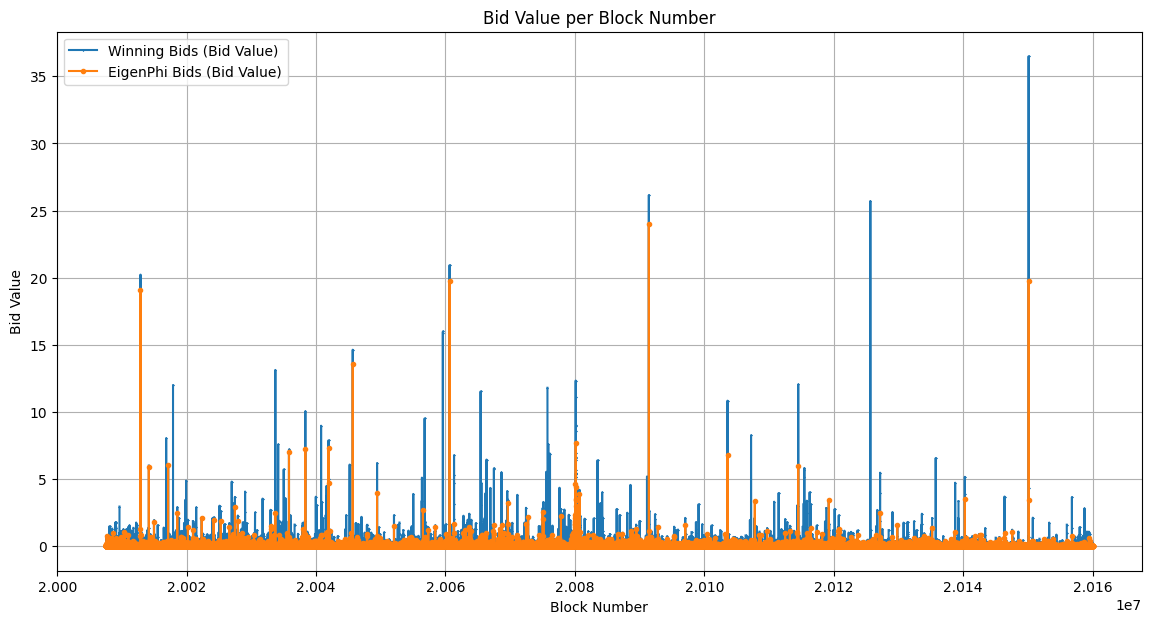

In [43]:


# 绘制线图
plt.figure(figsize=(14, 7))

# 绘制 df_filtered 的线图
plt.plot(df_filtered['block_number'], df_filtered['value_in_eth'], label='Winning Bids (Bid Value)', marker='x', markersize=1)

# 绘制 df_value_max 的线图
plt.plot(df_value_max['block_number'], df_value_max['value_in_eth'], label='EigenPhi Bids (Bid Value)', marker='o', markersize=3)

# 添加标题和标签
plt.title('Bid Value per Block Number')
plt.xlabel('Block Number')
plt.ylabel('Bid Value')
plt.legend()
plt.grid(True)

# 显示图表
plt.show()


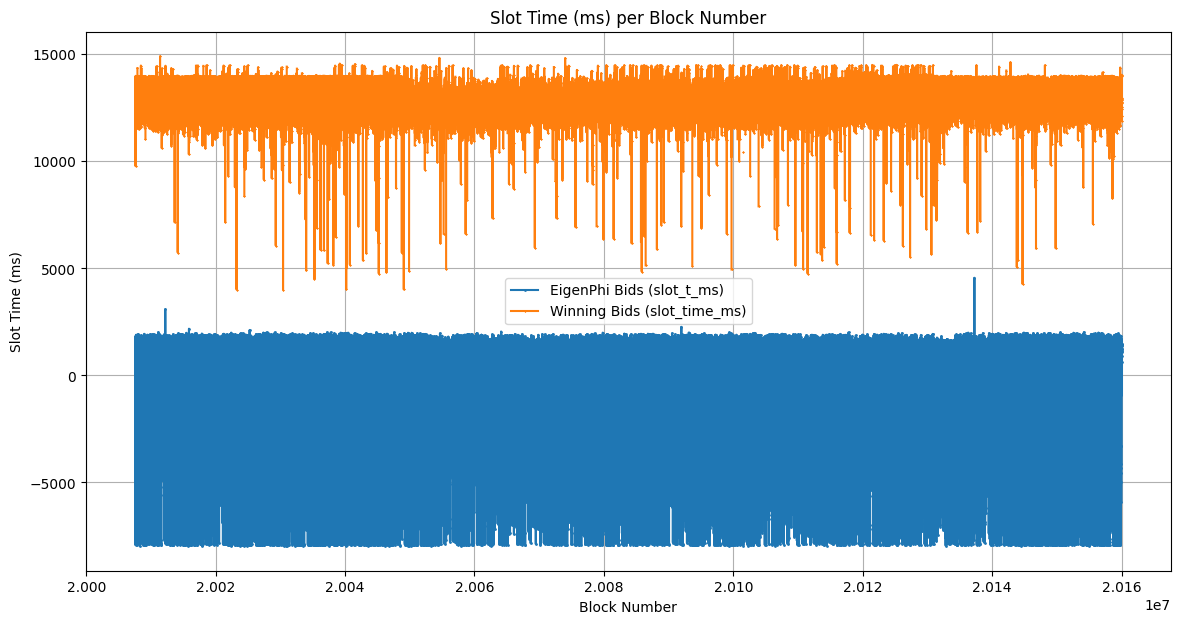

In [45]:


# 绘制线图并调整标记大小
plt.figure(figsize=(14, 7))

# 绘制 df_value_max 的线图 (使用 slot_t_ms 作为 y 轴)
plt.plot(df_value_max['block_number'], df_value_max['slot_t_ms'], label='EigenPhi Bids (slot_t_ms)', marker='o', markersize=1)

# 绘制 df_filtered 的线图 (使用 slot_time_ms 作为 y 轴)
plt.plot(df_filtered['block_number'], df_filtered['slot_time_ms'], label='Winning Bids (slot_time_ms)', marker='x', markersize=1)

# 添加标题和标签
plt.title('Slot Time (ms) per Block Number')
plt.xlabel('Block Number')
plt.ylabel('Slot Time (ms)')
plt.legend()
plt.grid(True)

# 显示图表
plt.show()
